In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob, os

# Bmodes test

In [9]:
!ls /scratch/midway3/dhayaa/SHEARTESTS/GOLD_WithoutBit2048

BrighterFatter_bins.npy  BrighterFatter.npy  psf_inds.npy  shear_inds.npy


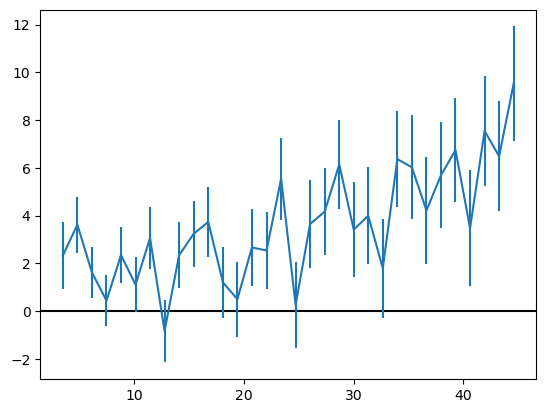

In [3]:
plt.axhline(0, color ='k')

RUN = '/scratch/midway3/dhayaa/SHEARTESTS/Ext0.2_Star5/'

A = np.load(RUN + '/Bmode.npy')
B = np.load(RUN + '/Bmode_Cov.npy')

plt.errorbar(np.sqrt(A[4]), 1e8*A[4]*(A[3] - np.mean(B[:, 3], axis= 0)).T, yerr = 1e8*A[4]*np.std(B[:, 3], axis= 0))


res = A[3] - np.mean(B[:, 3], axis= 0)
cov = np.cov(B[:, 3].T)
inv = np.linalg.inv(cov)


#     print((res @ inv @ res)/len(A[3]))

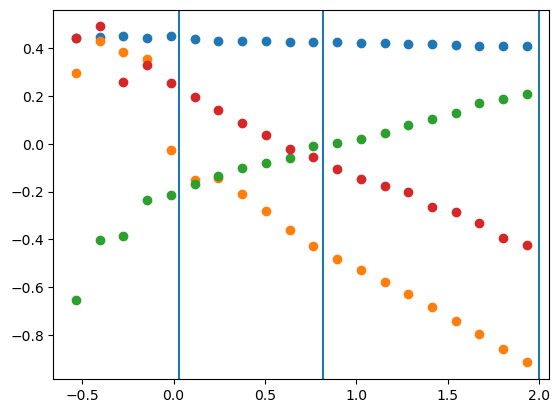

In [4]:
X = np.load(RUN + '/PSFColorBins_rz.npy')
Y = np.load(RUN + '/PSFColor_rz.npy')

plt.scatter(X, np.median(Y, axis = 0)[0])
plt.scatter(X, np.median(Y, axis = 0)[1])
plt.scatter(X, np.median(Y, axis = 0)[2])
plt.scatter(X, np.median(Y, axis = 0)[3])

plt.axvline(0.027)
plt.axvline(0.817)
plt.axvline(2.0)

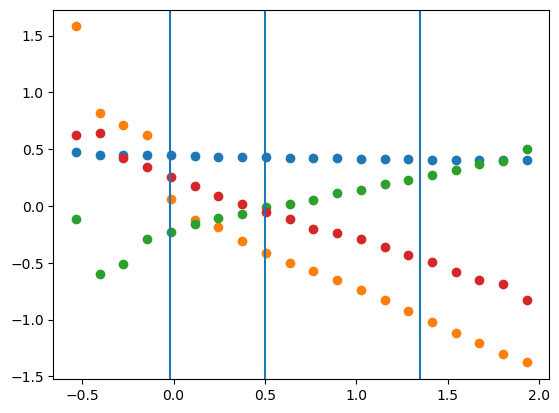

In [5]:
X = np.load(RUN + '/PSFColorBins_ri.npy')
Y = np.load(RUN + '/PSFColor_ri.npy')

plt.scatter(X, np.median(Y, axis = 0)[0])
plt.scatter(X, np.median(Y, axis = 0)[1])
plt.scatter(X, np.median(Y, axis = 0)[2])
plt.scatter(X, np.median(Y, axis = 0)[3])

plt.axvline(-0.022)
plt.axvline(0.499)
plt.axvline(1.347)

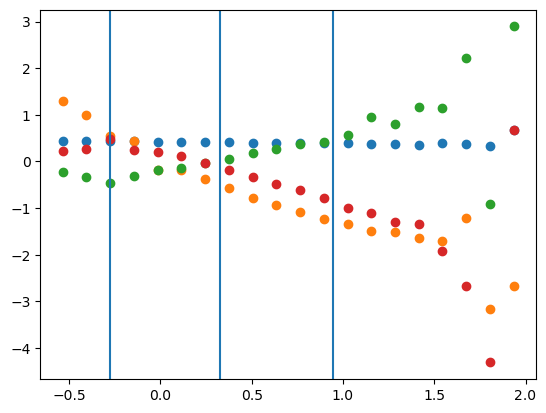

In [6]:
X = np.load(RUN + '/PSFColorBins_iz.npy')
Y = np.load(RUN + '/PSFColor_iz.npy')

plt.scatter(X, np.median(Y, axis = 0)[0])
plt.scatter(X, np.median(Y, axis = 0)[1])
plt.scatter(X, np.median(Y, axis = 0)[2])
plt.scatter(X, np.median(Y, axis = 0)[3])


plt.axvline(-0.276)
plt.axvline(0.325)
plt.axvline(0.945)

# Rho stats

In [7]:
def combine(X):
    
    return np.concatenate([np.concatenate([X_i[:, 3], X_i[:, 4]]) for X_i in X])

def split_array(arr):
    
    splits = [arr[i:i+50] for i in range(0, len(arr), 50)]  # split the array into 50-point chunks
    
#     print(splits)
    return splits

def cov_to_corr(cov):
    
    return cov/np.outer(np.sqrt(np.diagonal(cov)), np.sqrt(np.diagonal(cov)))

In [14]:
OUT = {}
    
cov = np.loadtxt(RUN + '/taustats_All_cov_treecorr.txt')
cov = cov[50:, 50:]

tau_cov = cov[-150:, -150:]

inv_tau_cov = np.linalg.inv(tau_cov)


tau0_cov = cov[-150:-100,-150:-100]
tau1_cov = cov[-100:-50, -100:-50]
tau2_cov = cov[-50:,-50:]


inv_tau0_cov = np.linalg.inv(tau0_cov) 
inv_tau1_cov = np.linalg.inv(tau1_cov) 
inv_tau2_cov = np.linalg.inv(tau2_cov) 


datavectors = [np.loadtxt(RUN + '/taustats_shear_2pt_treecorr.txt'),
               np.loadtxt(RUN + '/taustats_rho0_treecorr.txt'),
               np.loadtxt(RUN + '/taustats_rho1_treecorr.txt'),
               np.loadtxt(RUN + '/taustats_rho2_treecorr.txt'),
               np.loadtxt(RUN + '/taustats_rho3_treecorr.txt'),
               np.loadtxt(RUN + '/taustats_rho4_treecorr.txt'),
               np.loadtxt(RUN + '/taustats_rho5_treecorr.txt'),
               np.loadtxt(RUN + '/taustats_tau0_treecorr.txt'),
               np.loadtxt(RUN + '/taustats_tau1_treecorr.txt'),
               np.loadtxt(RUN + '/taustats_tau2_treecorr.txt')]

combined = combine(datavectors[:])

mean = combined[50:]

splits = split_array(mean)

import emcee

tau_data = np.concatenate(splits[-3:])

# Define the log-likelihood function
def log_likelihood(theta):

    alpha, beta, eta = theta

#     sampled_datavector = np.random.multivariate_normal(mean = mean, cov = cov, size = 1)[0]

#     rho0, rho1, rho2, rho3, rho4, rho5, tau0, tau1, tau2 = split_array(sampled_datavector)

    rho0, rho1, rho2, rho3, rho4, rho5, tau0, tau1, tau2 = splits

    tau0_model = alpha*rho0 + beta*rho2 + eta*rho5
    tau1_model = alpha*rho2 + beta*rho1 + eta*rho4
    tau2_model = alpha*rho5 + beta*rho4 + eta*rho3

    diff0 = tau0 - tau0_model
    diff1 = tau1 - tau1_model
    diff2 = tau2 - tau2_model

    chi2 = (diff0 @ inv_tau0_cov @ diff0 + 
            diff1 @ inv_tau1_cov @ diff1 + 
            diff2 @ inv_tau2_cov @ diff2)
#     model = np.concatenate([tau0_model, tau1_model, tau2_model])

#     diff = tau_data - model

#     chi2 = diff @ inv_tau_cov @ diff

#     chi2 = np.sum(diff**2/np.diagonal(tau_cov))

    return -chi2

# Define the log-prior function
def log_prior(theta):
    # Set uniform priors for a, b, c between -10 and 10
    if (-10 < theta[0] < 10) and (-10 < theta[1] < 10) and (-10 < theta[2] < 10):
        return 0.0
    else:
        return -np.inf

# Define the log-posterior function
def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

# Set up the emcee sampler
ndim = 3
nwalkers = 100
pos = np.random.multivariate_normal([0.001, 0, 0], cov = np.diag([0.01, 0.5, 0.1])**2, size = nwalkers)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

# Burn in the sampler
pos, _, _ = sampler.run_mcmc(pos, 1000, progress = True)

# Run the sampler for 1000 steps
sampler.reset()
sampler.run_mcmc(pos, 2000, progress = True)

# Get the samples and flatten the chains
samples = sampler.chain[:, :, :].reshape((-1, ndim))

OUT[RUN] = samples

# Print the median and 1-sigma uncertainties of a, b, c
a_median, b_median, c_median = np.median(samples, axis=0)
a_err = np.percentile(samples[:, 0], [16, 84]) - a_median
b_err = np.percentile(samples[:, 1], [16, 84]) - b_median
c_err = np.percentile(samples[:, 2], [16, 84]) - c_median

print("----------------------------------")
print("----------------------------------")
print(RUN)
print("a = {:.4f} +/- {:.4f}".format(a_median, np.mean(np.abs(a_err))))
print("b = {:.4f} +/- {:.4f}".format(b_median, np.mean(np.abs(b_err))))
print("c = {:.4f} +/- {:.4f}".format(c_median, np.mean(np.abs(c_err))))
print("----------------------------------")

100%|██████████| 2000/2000 [00:05<00:00, 342.68it/s]

----------------------------------
----------------------------------
/scratch/midway3/dhayaa/SHEARTESTS/Ext0.2_Star5/
a = 0.0002 +/- 0.0020
b = 1.2512 +/- 0.0372
c = -2.3445 +/- 0.6123
----------------------------------


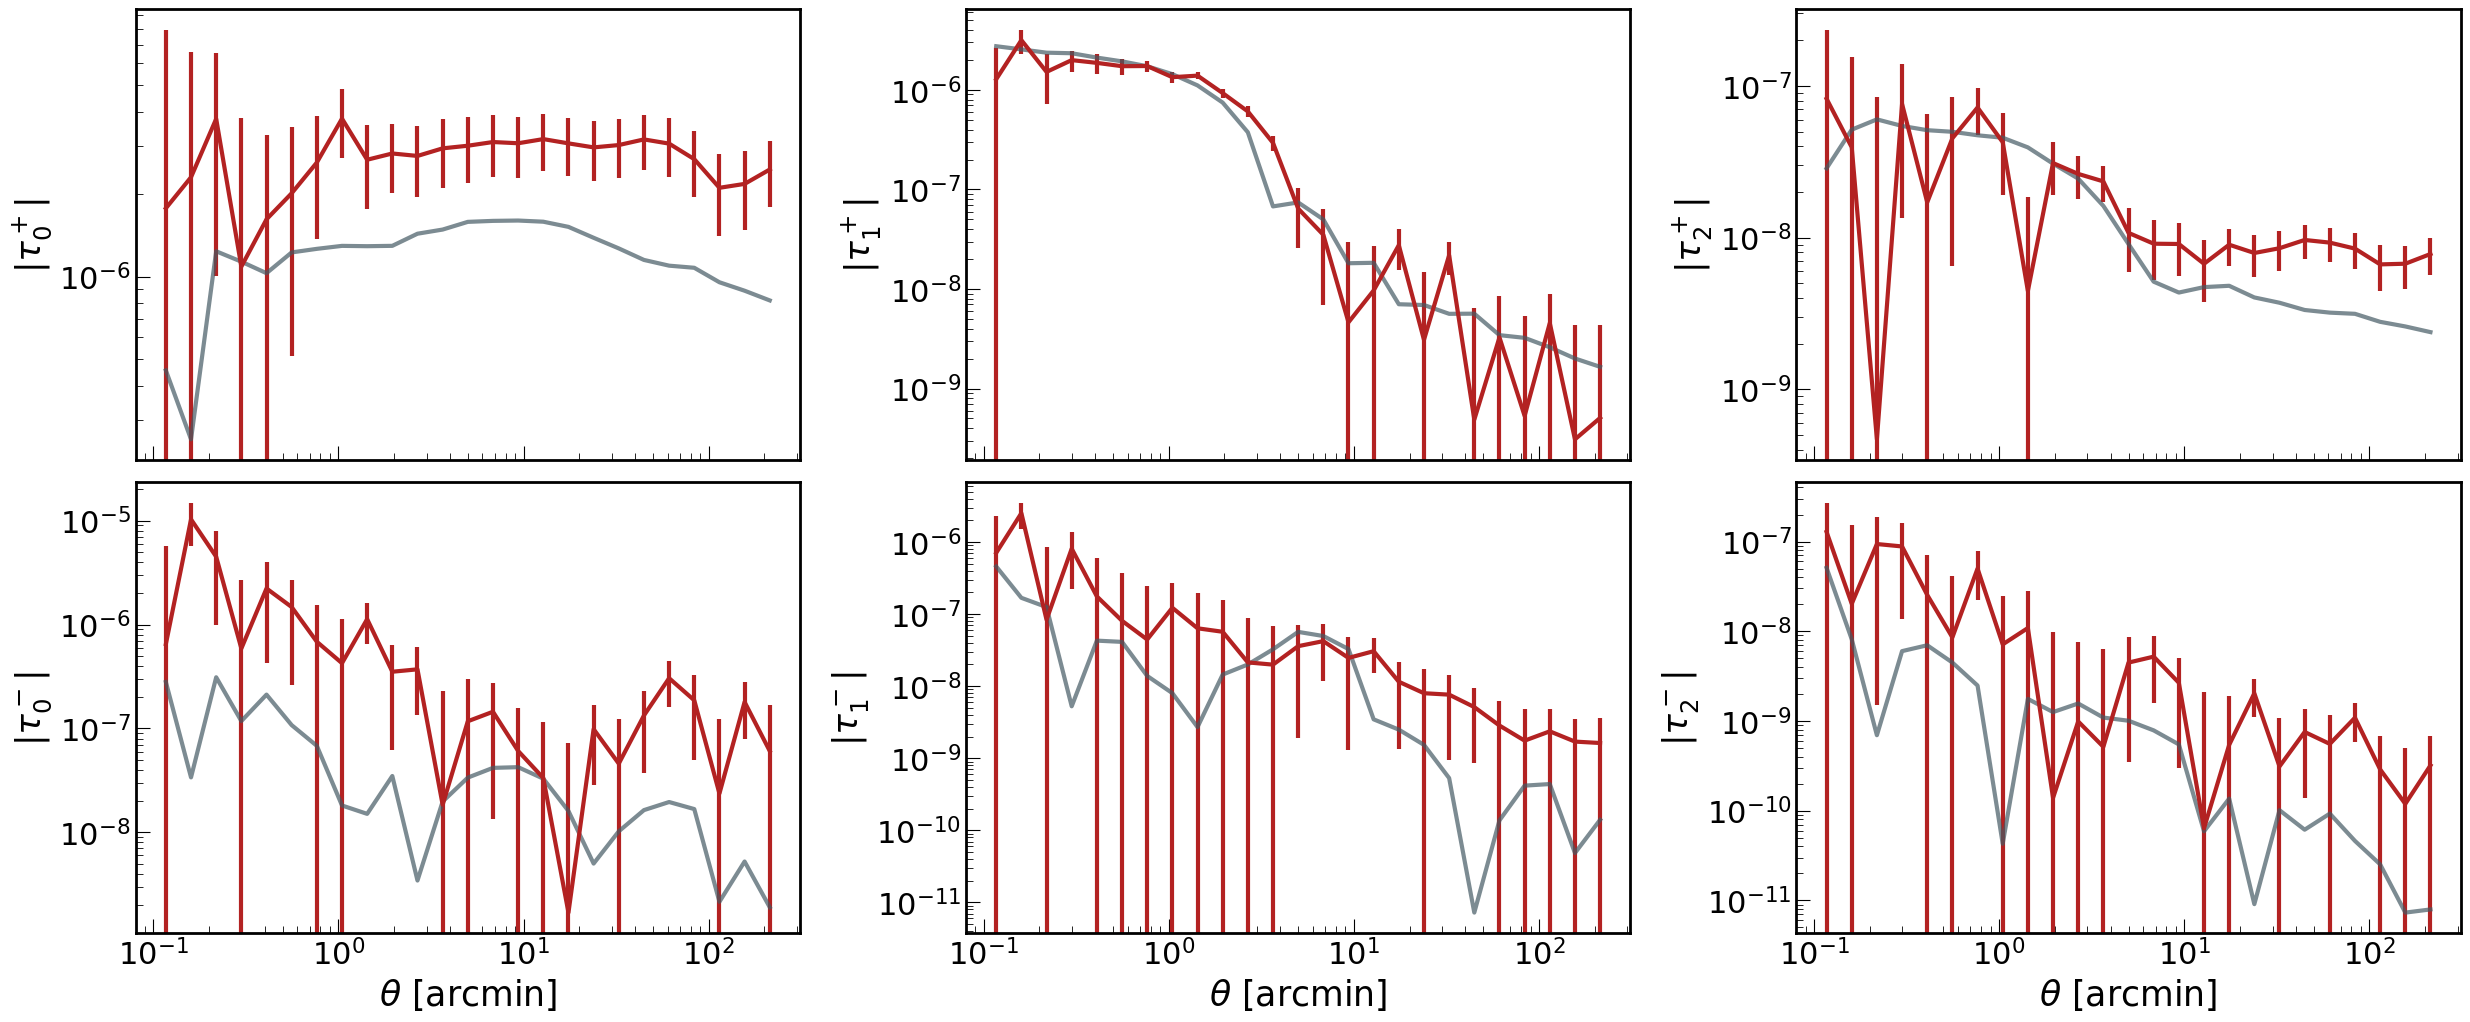

In [15]:
plt.rcParams["axes.linewidth"]  = 2.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [10, 10]
plt.rc("font", size=22)

fig, ax = plt.subplots(2, 3, figsize = (30, 12), sharex = True)

plt.subplots_adjust(hspace = 0.05, wspace = 0.25)

[a.loglog() for a in ax.flatten()]

for i in range(3):
    
    x = np.loadtxt('/scratch/midway3/dhayaa/SHEARTESTS//Ext0.2_Star5/taustats_tau%d_treecorr.txt' % i)
    ax.flatten()[i].errorbar(x[:, 0], np.abs(x[:, 3]), yerr = x[:, 7], color = '#B32222', lw = 3)
    ax.flatten()[i + 3].errorbar(x[:, 0], np.abs(x[:, 4]), yerr = x[:, 8], color = '#B32222', lw = 3)
    
    
ax.flatten()[0].plot(x[:, 0], np.abs(datavectors[1][:, 3] * a_median + 
                                     datavectors[3][:, 3] * b_median + 
                                     datavectors[6][:, 3] * c_median), color = '#455A64', lw = 3, alpha = 0.7)

ax.flatten()[3].plot(x[:, 0], np.abs(datavectors[1][:, 4] * a_median + 
                                     datavectors[3][:, 4] * b_median + 
                                     datavectors[6][:, 4] * c_median), color = '#455A64', lw = 3, alpha = 0.7)


ax.flatten()[1].plot(x[:, 0], np.abs(datavectors[3][:, 3] * a_median + 
                                     datavectors[2][:, 3] * b_median + 
                                     datavectors[5][:, 3] * c_median), color = '#455A64', lw = 3, alpha = 0.7)

ax.flatten()[4].plot(x[:, 0], np.abs(datavectors[3][:, 4] * a_median + 
                                     datavectors[2][:, 4] * b_median + 
                                     datavectors[5][:, 4] * c_median), color = '#455A64', lw = 3, alpha = 0.7)


ax.flatten()[2].plot(x[:, 0], np.abs(datavectors[6][:, 3] * a_median + 
                                     datavectors[5][:, 3] * b_median + 
                                     datavectors[4][:, 3] * c_median), color = '#455A64', lw = 3, alpha = 0.7)

ax.flatten()[5].plot(x[:, 0], np.abs(datavectors[6][:, 4] * a_median + 
                                     datavectors[5][:, 4] * b_median + 
                                     datavectors[4][:, 4] * c_median), color = '#455A64', lw = 3, alpha = 0.7)
    
for i, l in enumerate([r'$\tau_0^+$',
                       r'$\tau_1^+$',
                       r'$\tau_2^+$',
                       r'$\tau_0^-$',
                       r'$\tau_1^-$',
                       r'$\tau_2^-$']):
    ax.flatten()[i].set_ylabel(r'|%s|' % l, size = 25)
    
    
[ax.flatten()[i].set_xlabel(r'$\theta$ [arcmin]', size = 25) for i in [3, 4, 5]];

# plt.savefig('./plots/Tau_Stats.pdf', bbox_inches = 'tight', dpi = 400)

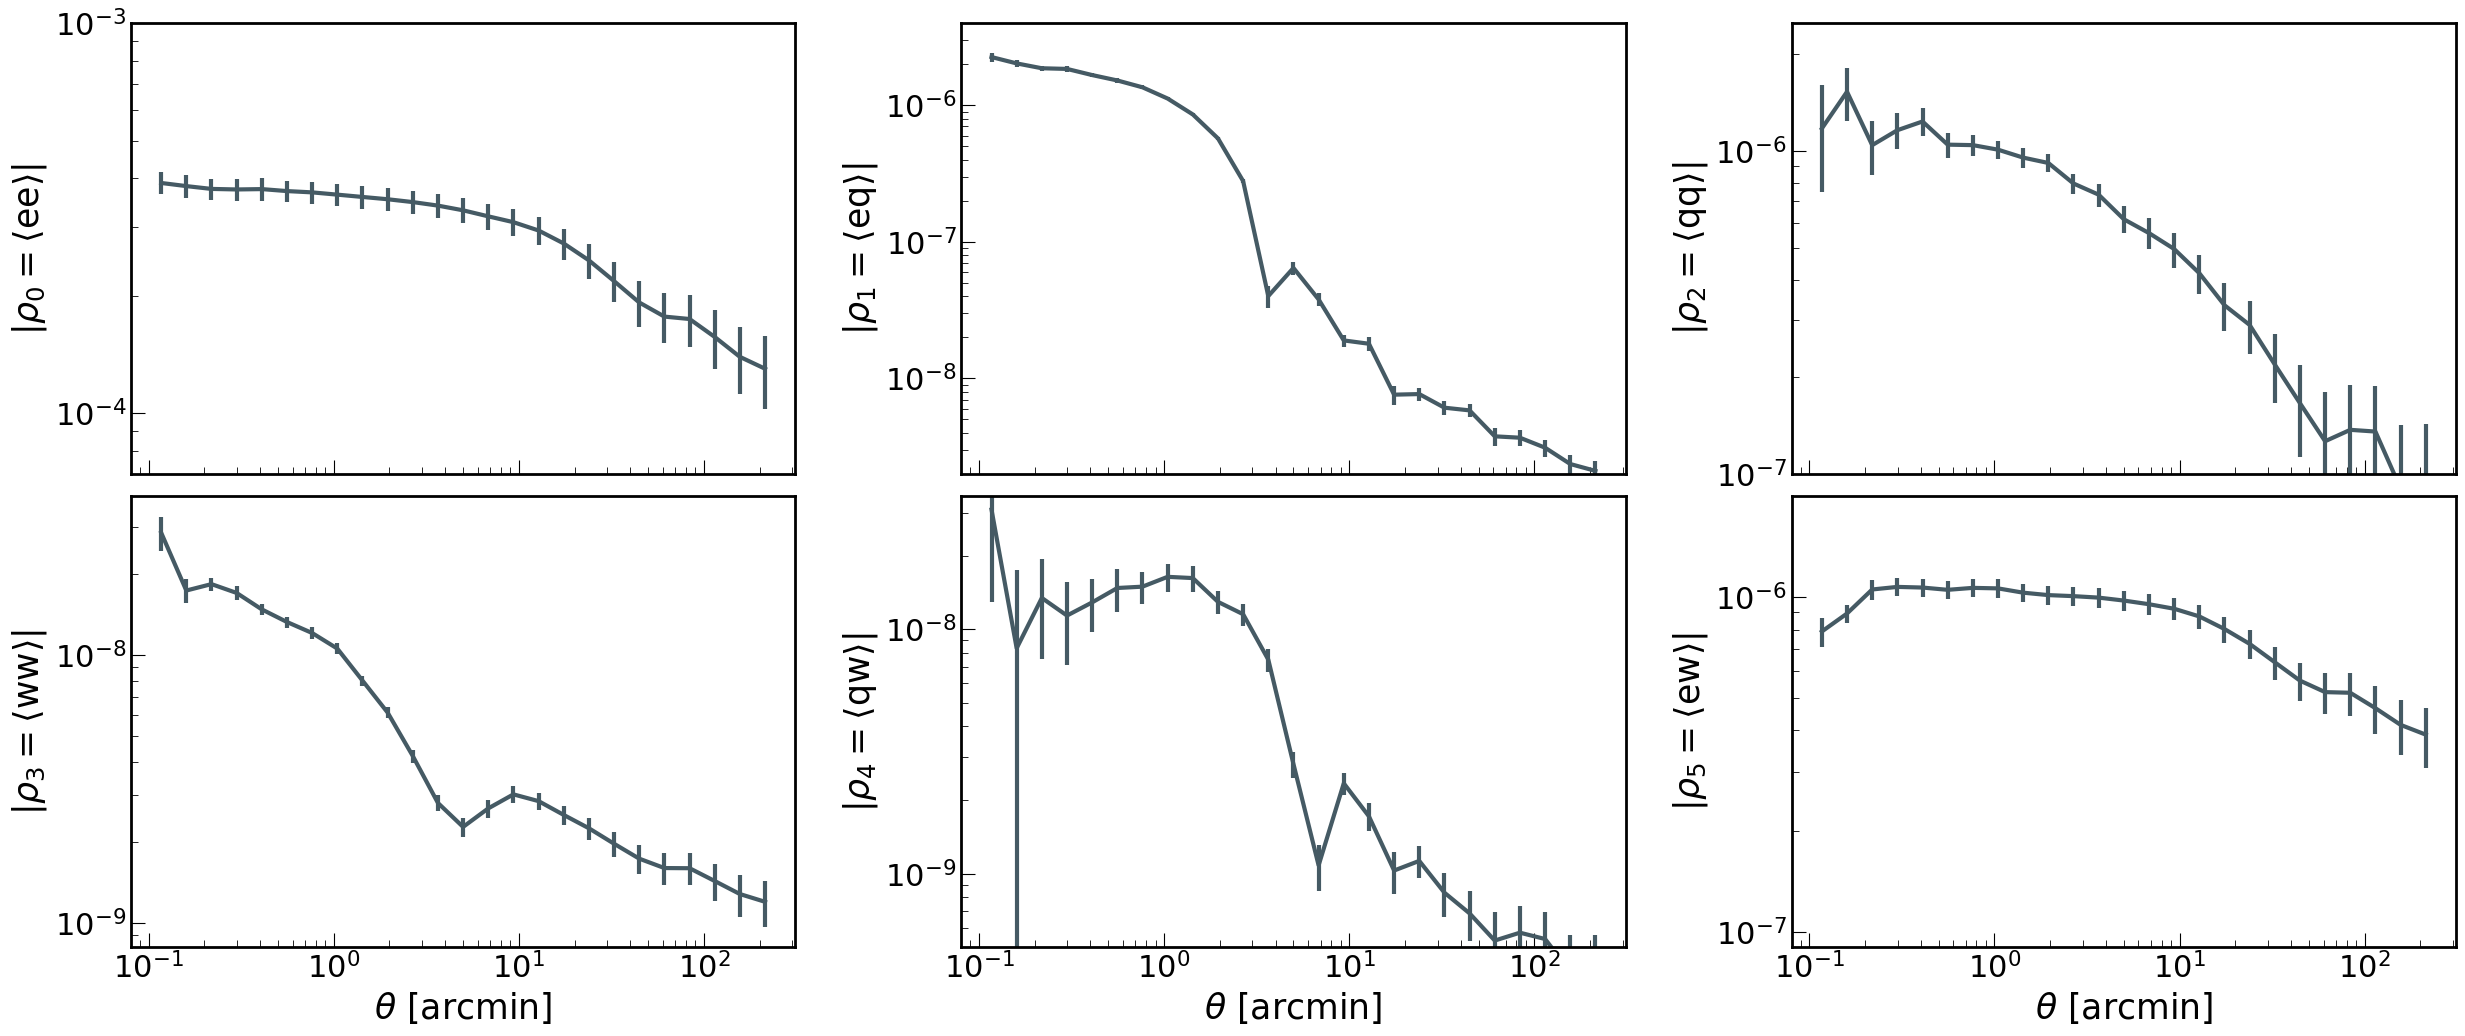

In [17]:
plt.rc("font", size=22)

fig, ax = plt.subplots(2, 3, figsize = (30, 12), sharex = True)

plt.subplots_adjust(hspace = 0.05, wspace = 0.25)

[a.loglog() for a in ax.flatten()]

for i in range(6):
    
    x = np.loadtxt(RUN + '/taustats_rho%d_treecorr.txt' % i)
#     ax.flatten()[i].fill_between(x[:, 0], np.abs(x[:, 3]) + x[:, 7], np.abs(x[:, 3]) - x[:, 7], color = '#455A64', alpha = 0.6, lw = 3)
    ax.flatten()[i].errorbar(x[:, 0], np.abs(x[:, 3]), yerr = x[:, 7], color = '#455A64', lw = 3)

for i, l in enumerate([r'$\rho_0 = \langle {\rm ee} \rangle$',
                       r'$\rho_1 = \langle {\rm eq} \rangle$',
                       r'$\rho_2 = \langle {\rm qq} \rangle$',
                       r'$\rho_3 = \langle {\rm ww} \rangle$',
                       r'$\rho_4 = \langle {\rm qw} \rangle$',
                       r'$\rho_5 = \langle {\rm ew} \rangle$']):
    ax.flatten()[i].set_ylabel(r'|%s|' % l, size = 25)
    
[ax.flatten()[i].set_xlabel(r'$\theta$ [arcmin]', size = 25) for i in [3, 4, 5]];

ax.flatten()[0].set_ylim(7e-5, 1e-3)
ax.flatten()[1].set_ylim(2e-9, 4e-6)
ax.flatten()[2].set_ylim(1e-7, 2.5e-6)

ax.flatten()[4].set_ylim(5e-10, 3.5e-8)
ax.flatten()[5].set_ylim(9e-8, 2e-6)

[ax.flatten()[i].set_xlabel(r'$\theta$ [arcmin]', size = 25) for i in [3, 4, 5]];

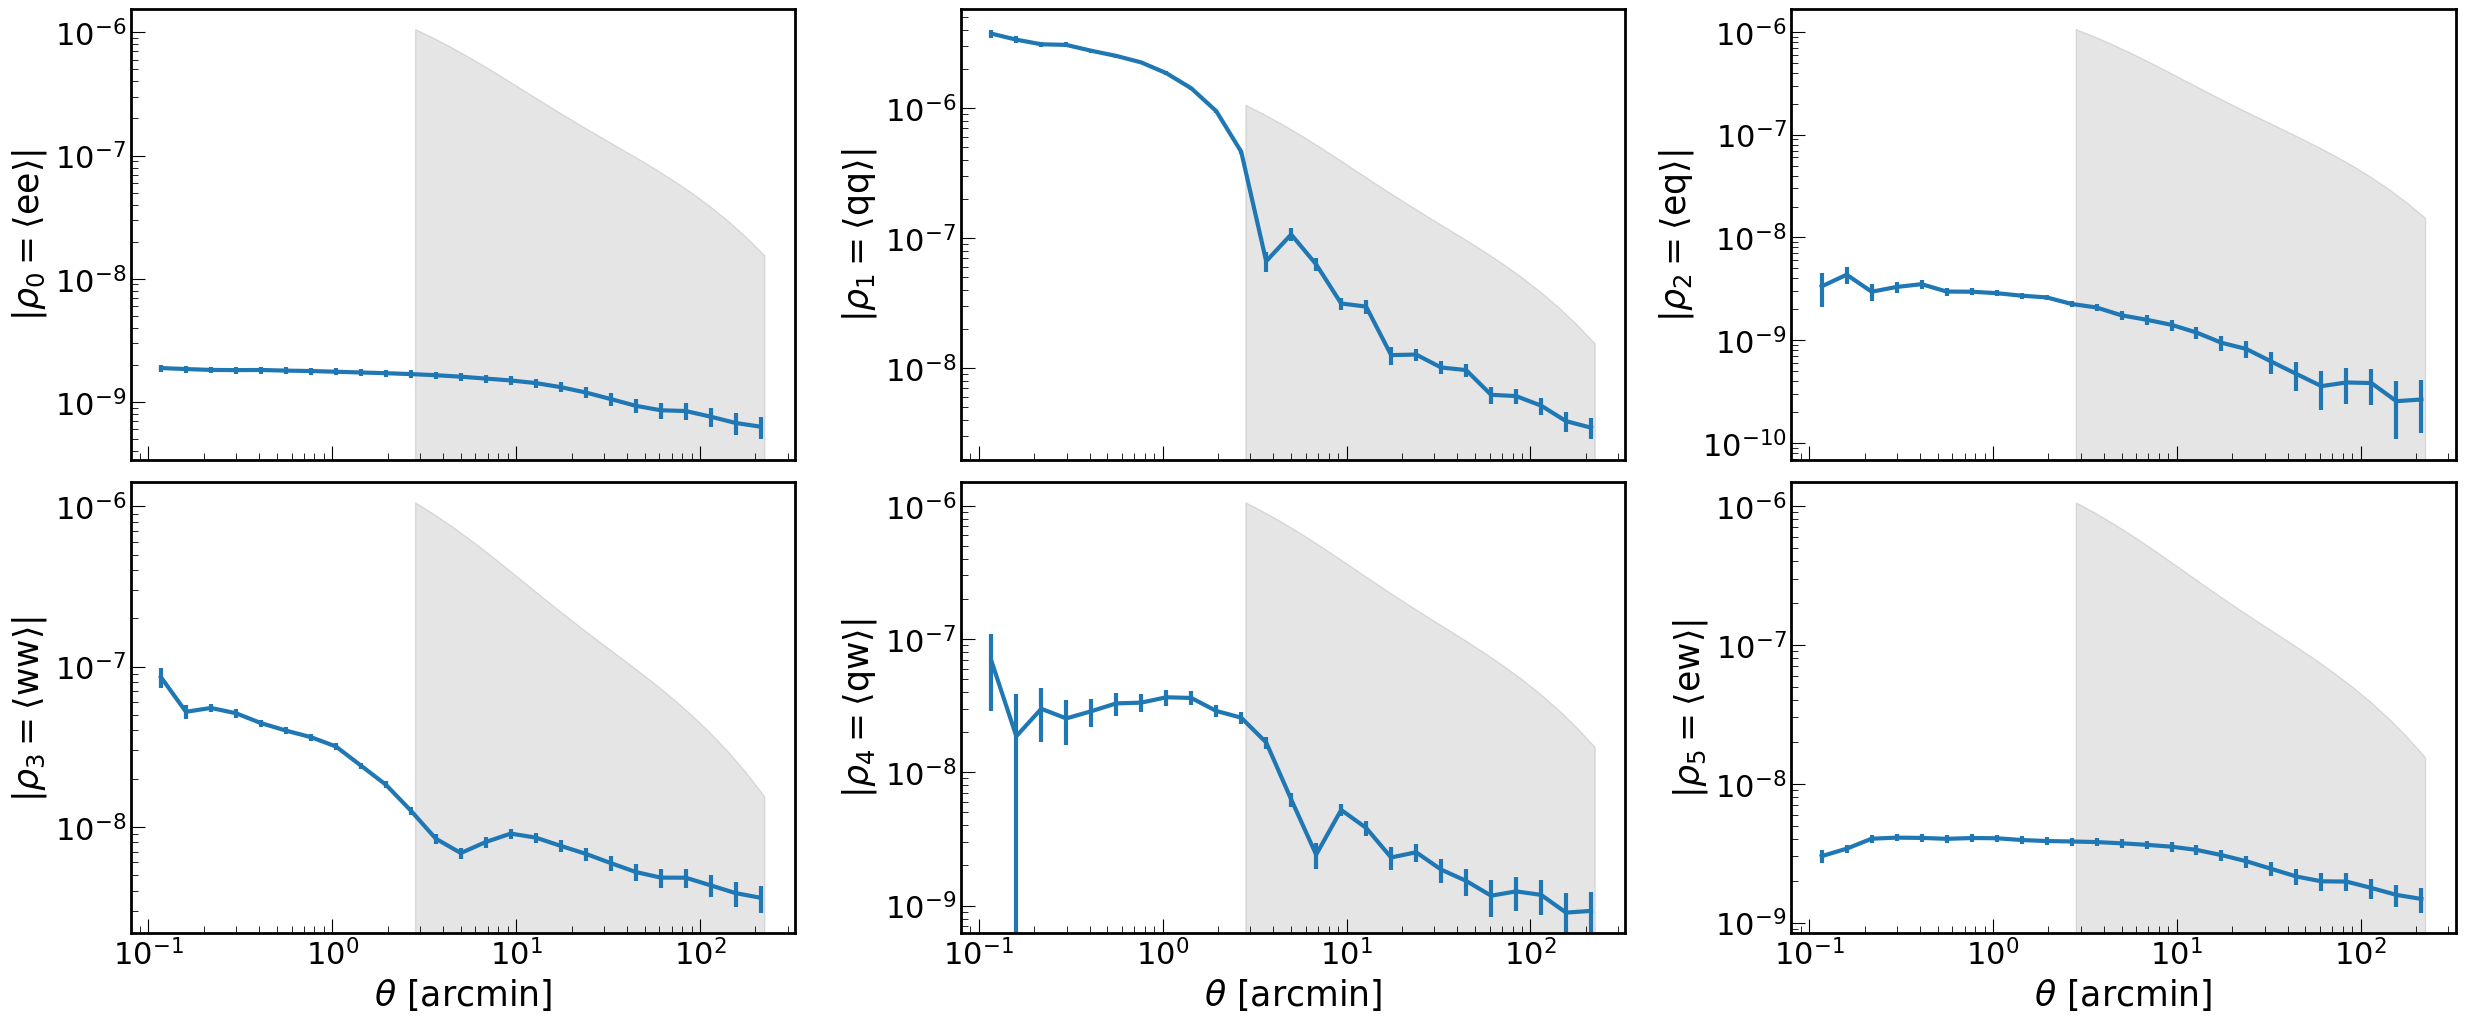

In [34]:
from astropy.io import fits

plt.rc("font", size=22)

fig, ax = plt.subplots(2, 3, figsize = (30, 12), sharex = True)

plt.subplots_adjust(hspace = 0.05, wspace = 0.25)

[a.loglog() for a in ax.flatten()]

    
a = a_median + np.mean(np.abs(a_err))
b = b_median + np.mean(np.abs(b_err))
e = c_median + np.mean(np.abs(c_err))

coeffs = [a*a, b*b, a*b, e*e, b*e, a*e]
for i in range(6):

    x = np.loadtxt(RUN + '/taustats_rho%d_treecorr.txt' % i)
    ax.flatten()[i].errorbar(x[:, 0], np.abs(coeffs[i]) * np.abs(x[:, 3]), yerr = np.abs(coeffs[i]) * x[:, 7], lw = 3)
        

xi_plus_11 = fits.open('/project/chihway/dhayaa/DECADE/cosmosis/Lucas_files/simulated_shear_Oct17th.fits')[2].data[:20]
for i in range(6):
    ax.flatten()[i].fill_between(xi_plus_11['ANG'], np.zeros(20), 0.1*xi_plus_11['VALUE'], color = 'k', alpha = 0.1)
    
    

for i, l in enumerate([r'$\rho_0 = \langle {\rm ee} \rangle$',
                       r'$\rho_1 = \langle {\rm qq} \rangle$',
                       r'$\rho_2 = \langle {\rm eq} \rangle$',
                       r'$\rho_3 = \langle {\rm ww} \rangle$',
                       r'$\rho_4 = \langle {\rm qw} \rangle$',
                       r'$\rho_5 = \langle {\rm ew} \rangle$']):
    ax.flatten()[i].set_ylabel(r'|%s|' % l, size = 25)
    
[ax.flatten()[i].set_xlabel(r'$\theta$ [arcmin]', size = 25) for i in [3, 4, 5]];

# ax.flatten()[0].set_ylim(7e-5, 1e-3)
# ax.flatten()[1].set_ylim(2e-9, 4e-6)
# ax.flatten()[2].set_ylim(1e-7, 2.5e-6)

# ax.flatten()[4].set_ylim(5e-10, 3.5e-8)
# ax.flatten()[5].set_ylim(9e-8, 2e-6)

[ax.flatten()[i].set_xlabel(r'$\theta$ [arcmin]', size = 25) for i in [3, 4, 5]];

70.77808258332244 2.8311233033328977


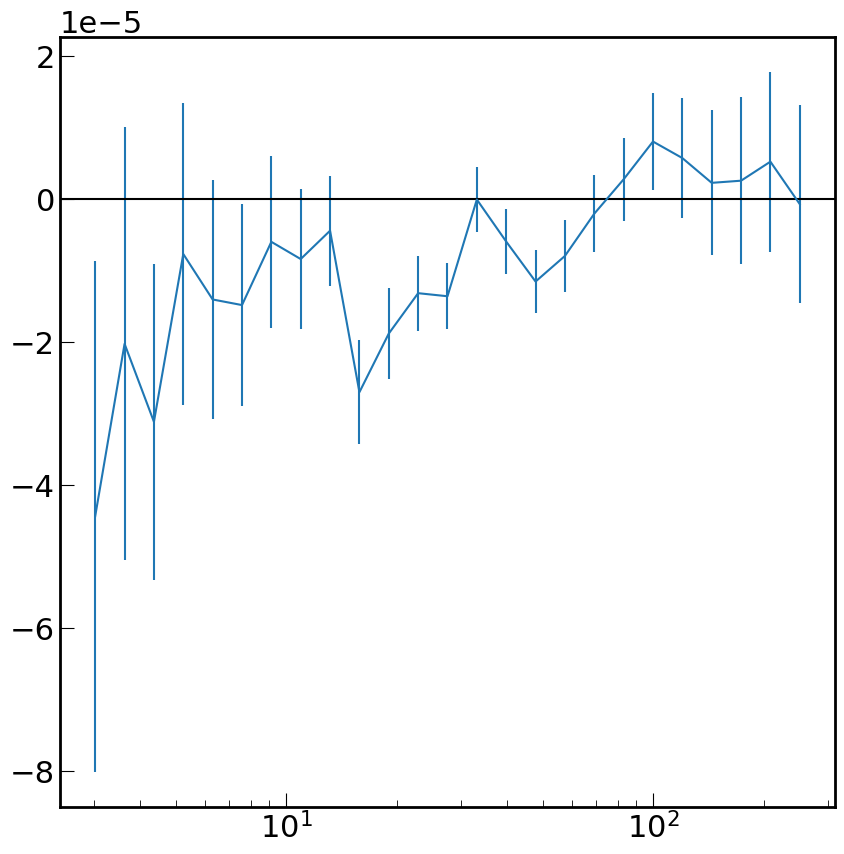

In [18]:
import matplotlib.pyplot as plt
plt.xscale('log')

X = np.loadtxt(RUN + '/starshears_bright_treecorr.txt')
Y = np.loadtxt(RUN + '/starshears_bright_rands_treecorr.txt')
Z = np.loadtxt(RUN + '/starshears_bright_cov_treecorr.txt')

# plt.plot(X[:, 0], (X - Y)[:, 3])
# plt.plot(X[:, 0], (X - Y)[:, 4])

# plt.errorbar(X[:, 0], (X)[:, 3], yerr = Y[:, 5])
# plt.errorbar(X[:, 0], (X)[:, 4], yerr = Y[:, 5])

d = (X[:, 3] - Y[:, 3])
inv = np.linalg.inv(Z)

chi2 = d @ inv @ d

print(chi2, chi2/len(d))
plt.errorbar(X[:, 0] * (1 + 0.1), (X - Y)[:, 3], yerr = (X)[:, 5])
# plt.errorbar(X[:, 0], (X - Y)[:, 4], yerr = (X)[:, 5])

plt.axhline(color = 'k')

82.24740728914323 3.289896291565729


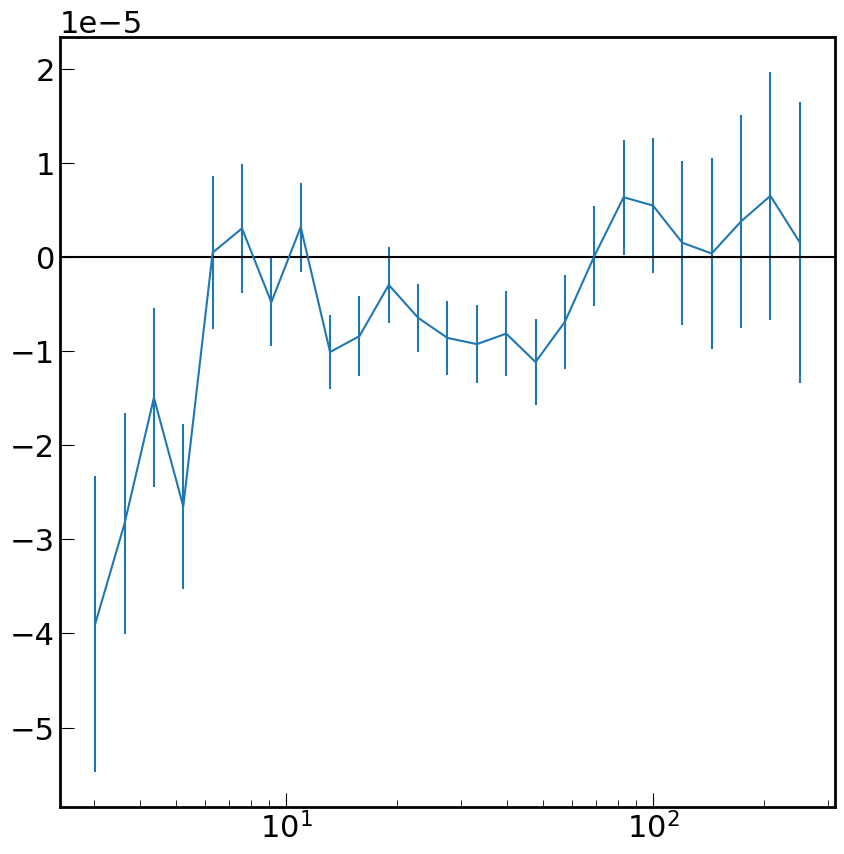

In [19]:
import matplotlib.pyplot as plt
plt.xscale('log')

X = np.loadtxt(RUN + '/starshears_faint_treecorr.txt')
Y = np.loadtxt(RUN + '/starshears_faint_rands_treecorr.txt')
Z = np.loadtxt(RUN + '/starshears_faint_cov_treecorr.txt')

# plt.plot(X[:, 0], (X - Y)[:, 3])
# plt.plot(X[:, 0], (X - Y)[:, 4])

# plt.errorbar(X[:, 0], (X)[:, 3], yerr = Y[:, 5])
# plt.errorbar(X[:, 0], (X)[:, 4], yerr = Y[:, 5])

d = (X[:, 3] - Y[:, 3])
inv = np.linalg.inv(Z)

chi2 = d @ inv @ d

print(chi2, chi2/len(d))
plt.errorbar(X[:, 0] * (1 + 0.1), (X - Y)[:, 3], yerr = (X)[:, 5])
# plt.errorbar(X[:, 0], (X - Y)[:, 4], yerr = (X)[:, 5])

plt.axhline(color = 'k')

0.9081224716272921


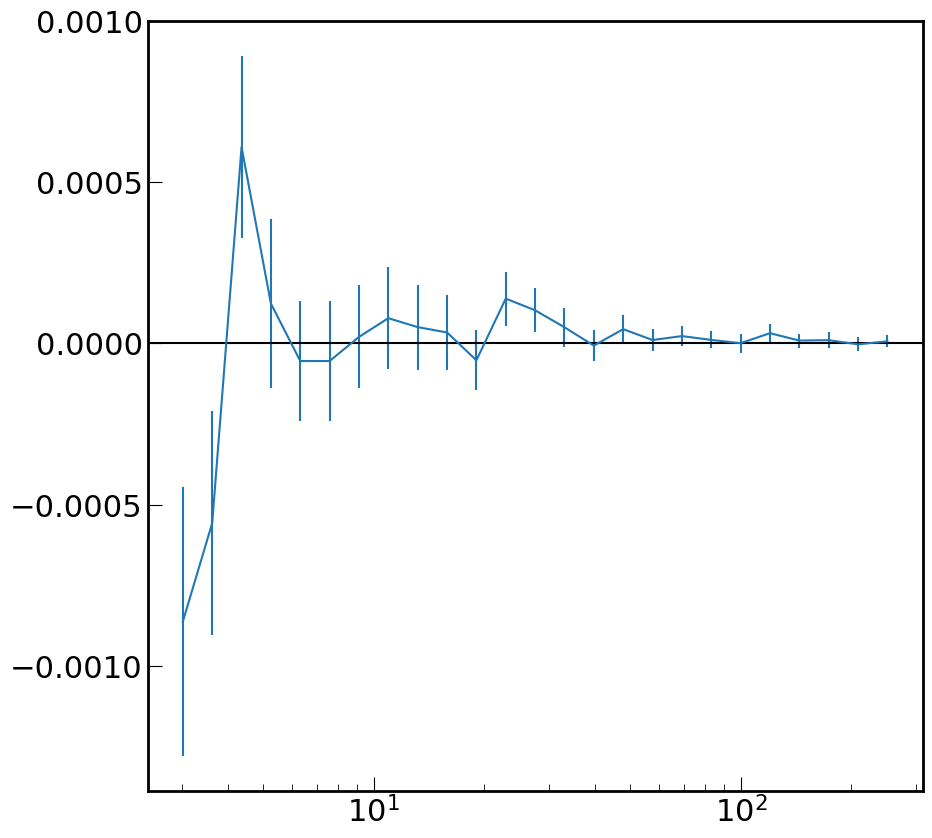

In [20]:
plt.xscale('log')

X = np.loadtxt(RUN + '/fieldcenter_treecorr.txt')
Y = np.loadtxt(RUN + '/fieldcenter_rands_treecorr.txt')
Z = np.loadtxt(RUN + '/fieldcenter_cov_treecorr.txt')

# plt.plot(X[:, 0], (X - Y)[:, 3])
# plt.plot(X[:, 0], (X - Y)[:, 4])

# plt.errorbar(X[:, 0], (X)[:, 3], yerr = Y[:, 5])
# plt.errorbar(X[:, 0], (X)[:, 4], yerr = Y[:, 5])

d = (X[:, 3] - Y[:, 3])
inv = np.linalg.inv(Z)

chi2 = d @ inv @ d

print(chi2/len(d))
plt.errorbar(X[:, 0] * (1 + 0.1), (X - Y)[:, 3], yerr = (X)[:, 5])
# plt.errorbar(X[:, 0], (X - Y)[:, 4], yerr = (X)[:, 5])

plt.axhline(color = 'k')

In [21]:
def jack_percentile(arr, perc):
    
    X = np.percentile(arr, perc, axis = 0)
    med = np.median(arr, axis = 0)
    
    return (X - med)*np.sqrt(arr.shape[0]) + med

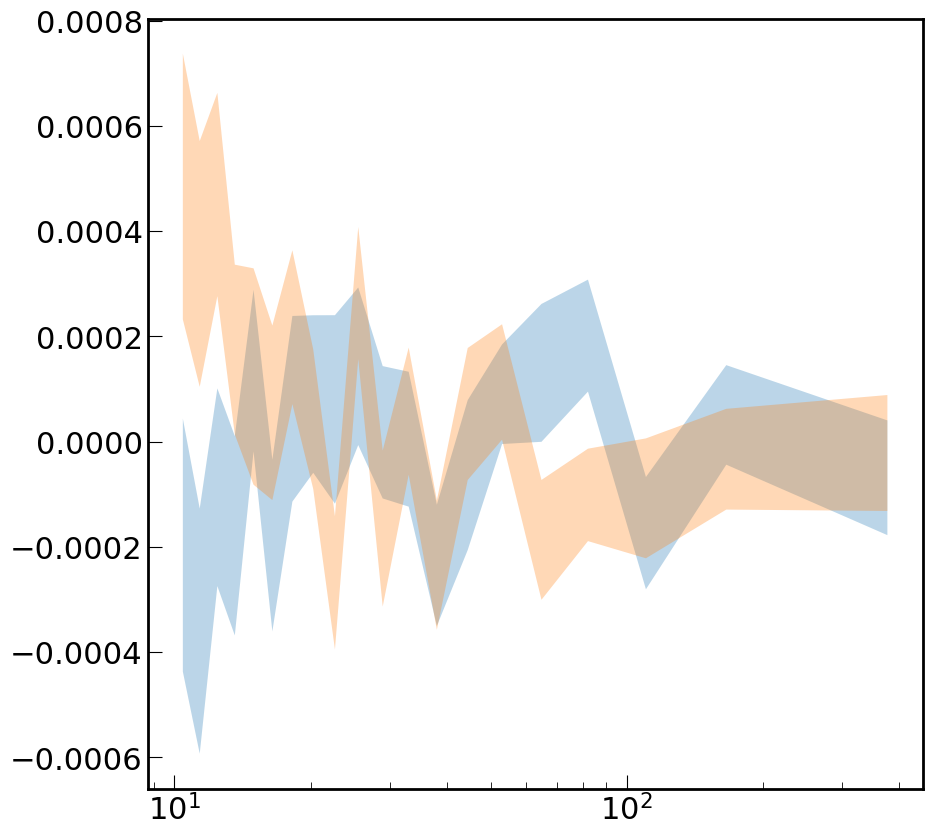

In [22]:
plt.xscale('log')

X = np.load(RUN + '/e_vs_SNR.npy')

# plt.plot(np.nanmean(X,axis = 1)[0], np.nanmean(X,axis = 1)[1])
plt.fill_between(np.nanmean(X,axis = 1)[0], jack_percentile(X[1], 16), jack_percentile(X[1], 84), alpha = 0.3)
plt.fill_between(np.nanmean(X,axis = 1)[0], jack_percentile(X[2], 16), jack_percentile(X[2], 84), alpha = 0.3)

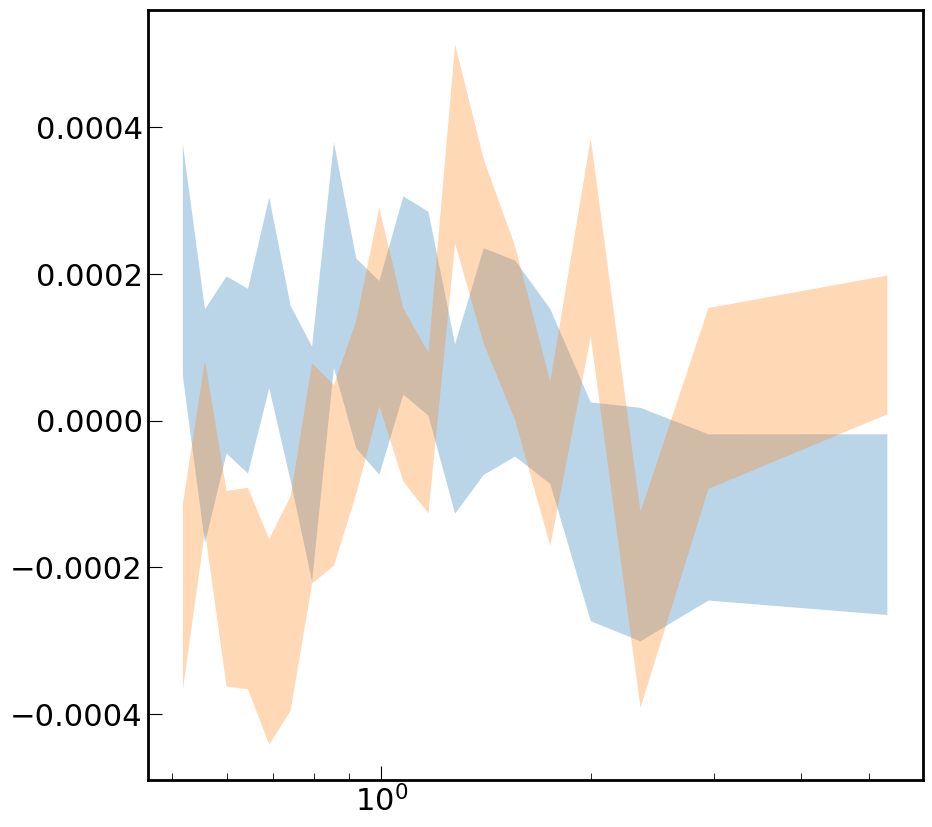

In [23]:
plt.xscale('log')

X = np.load(RUN + '/e_vs_Tratio.npy')

# plt.plot(np.nanmean(X,axis = 1)[0], np.nanmean(X,axis = 1)[1])
plt.fill_between(np.nanmean(X,axis = 1)[0], jack_percentile(X[1], 16), jack_percentile(X[1], 84), alpha = 0.3)
plt.fill_between(np.nanmean(X,axis = 1)[0], jack_percentile(X[2], 16), jack_percentile(X[2], 84), alpha = 0.3)

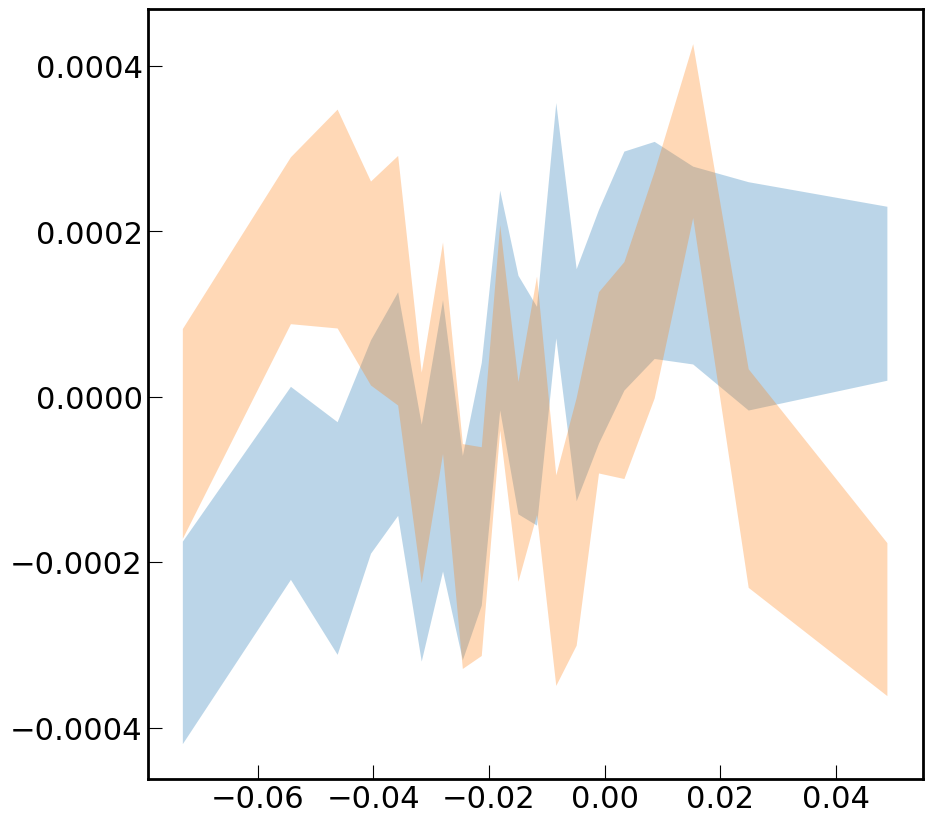

In [24]:
# plt.xscale('log')

X = np.load(RUN + '/e_vs_e2psf.npy')

# plt.plot(np.nanmean(X,axis = 1)[0], np.nanmean(X,axis = 1)[1])
plt.fill_between(np.nanmean(X,axis = 1)[0], jack_percentile(X[1], 16), jack_percentile(X[1], 84), alpha = 0.3)
plt.fill_between(np.nanmean(X,axis = 1)[0], jack_percentile(X[2], 16), jack_percentile(X[2], 84), alpha = 0.3)

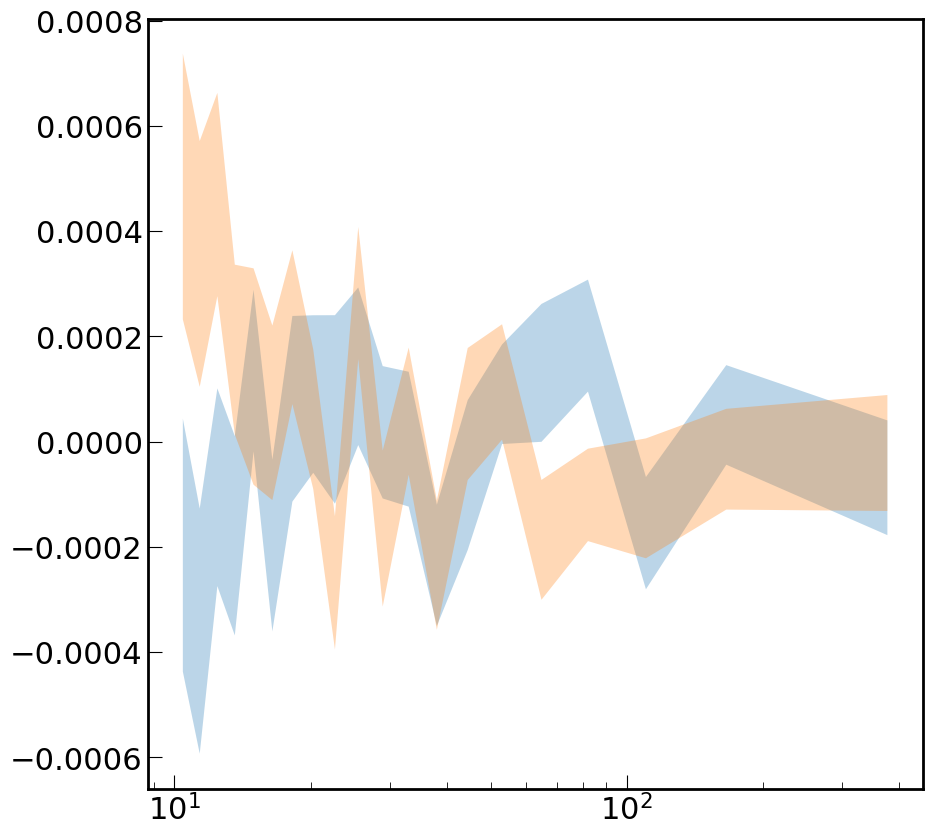

In [25]:
plt.xscale('log')

X = np.load(RUN + '/e_vs_SNR.npy')

# plt.plot(np.nanmean(X,axis = 1)[0], np.nanmean(X,axis = 1)[1])
plt.fill_between(np.nanmean(X,axis = 1)[0], jack_percentile(X[1], 16), jack_percentile(X[1], 84), alpha = 0.3)
plt.fill_between(np.nanmean(X,axis = 1)[0], jack_percentile(X[2], 16), jack_percentile(X[2], 84), alpha = 0.3)

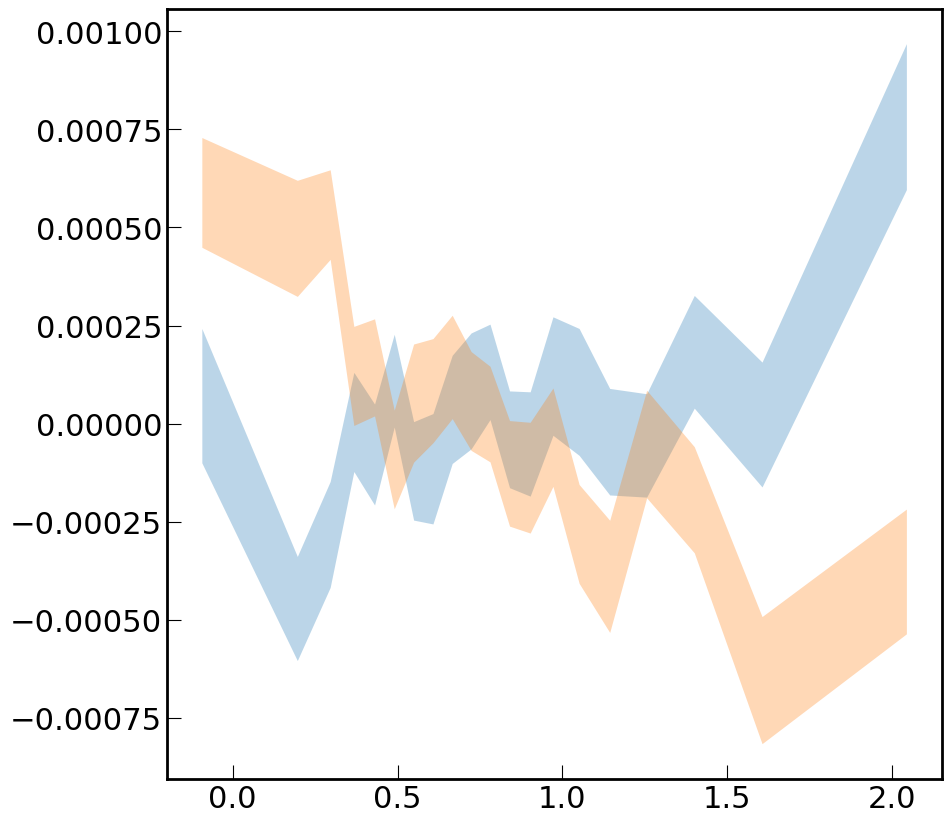

In [26]:
# plt.xscale('log')

X = np.load(RUN + '/e_vs_r_minus_z.npy')

plt.fill_between(np.nanmean(X,axis = 1)[0], jack_percentile(X[1], 16), jack_percentile(X[1], 84), alpha = 0.3)
plt.fill_between(np.nanmean(X,axis = 1)[0], jack_percentile(X[2], 16), jack_percentile(X[2], 84), alpha = 0.3)

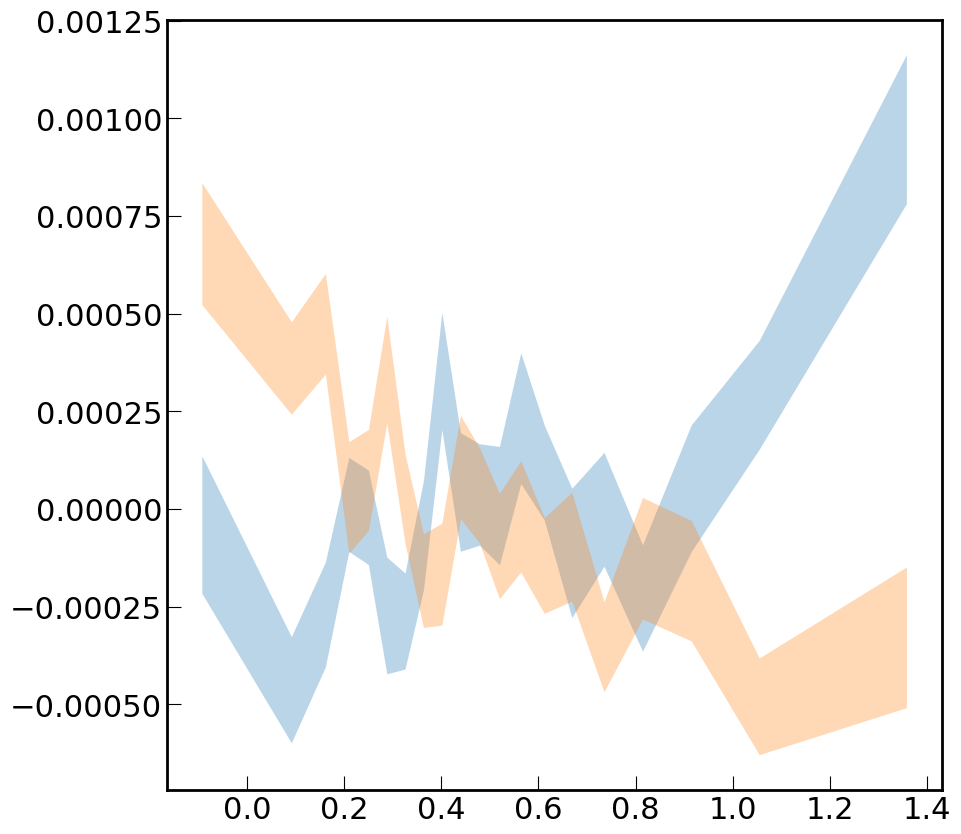

In [27]:
# plt.xscale('log')

X = np.load(RUN + '/e_vs_r_minus_i.npy')

plt.fill_between(np.nanmean(X,axis = 1)[0], jack_percentile(X[1], 16), jack_percentile(X[1], 84), alpha = 0.3)
plt.fill_between(np.nanmean(X,axis = 1)[0], jack_percentile(X[2], 16), jack_percentile(X[2], 84), alpha = 0.3)

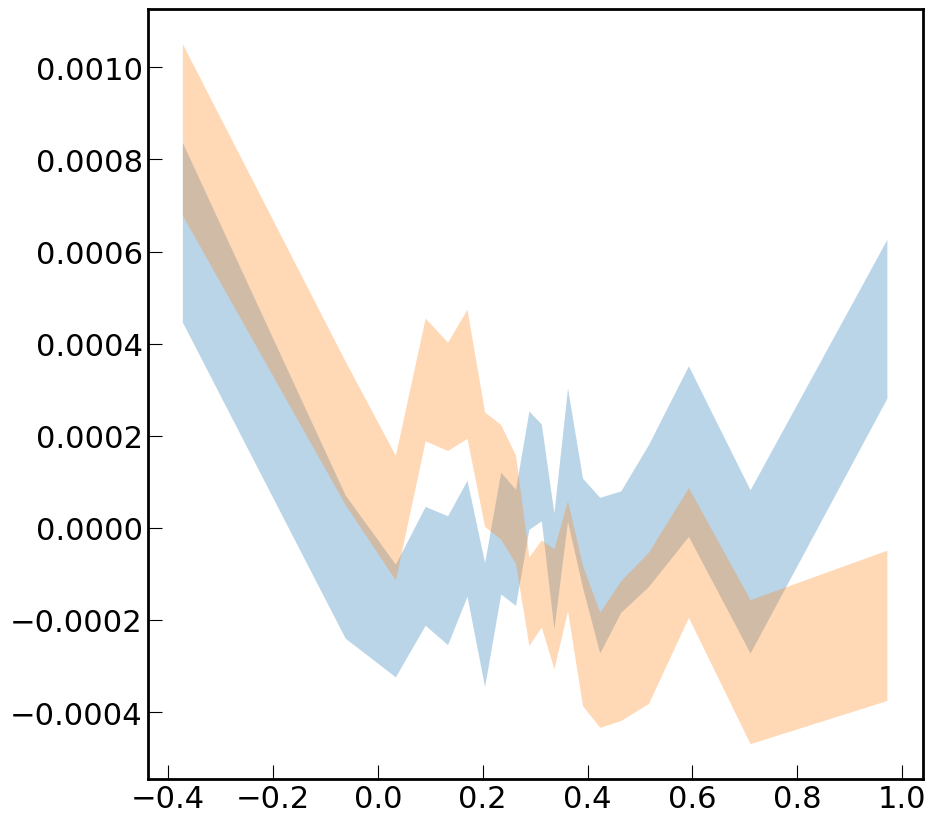

In [28]:
# plt.xscale('log')

X = np.load(RUN + '/e_vs_i_minus_z.npy')

plt.fill_between(np.nanmean(X,axis = 1)[0], jack_percentile(X[1], 16), jack_percentile(X[1], 84), alpha = 0.3)
plt.fill_between(np.nanmean(X,axis = 1)[0], jack_percentile(X[2], 16), jack_percentile(X[2], 84), alpha = 0.3)